In [1]:
using PorousMaterials
using PyPlot
using DataFrames
using CSV
using Interpolations
using Optim
using Printf
# PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf") # installs font
PyPlot.matplotlib.style.use("grandbudapest.mplstyle") # uses style

[1] Tam,  W.;  Jackson,  A.;  Nishida,  E.;  Ka-sai, Y.; Tsujihata, A.; Kajiwara, K. Designand  manufacture  of  the  ETS  VIII  xenontank.36thAIAA/ASME/SAE/ASEEJoint  Propulsion  Conference  and  Exhibit.2000; p 3677.(https://doi.org/10.2514/6.2000-3677)

[2] Welsch,  G.;  Boyer,  R.;  Collings,  E.Materials properties handbook: titanium alloys;ASM international, 1993. 

[3] Niinomi,   M.   Mechanical   properties   of biomedical  titanium  alloys. Materials Science and Engineering: A1998,243, 231–236.

[4] propellant storage considerations [link](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf)

define variables

Tank material anealed Ti-6Al-4V characteristics [1], [2], [3]

In [2]:
const ρ_t = 4428.785 # kg/m³ (convdrted from 0.16 lb/in³ listed in [2])
const σ_y = 8250.0 # bar Yield Strength (lower-limit of reported values [3])
const temperature = 298.0 # K
const β = 0.5 # safety factor -- need citation for choosing this.

0.5

Common amount of xenon gas required to bring into space [1].

In [3]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

mass_desired_xe_propellant = 89.0 # kg Xe
mol_desired_xe_propellant = mass_desired_xe_propellant * 1000 / xe_atomic_mass # mol Xe

677.8731539381383

read in density of xenon data (in bulk and adsorbed conditions)

In [4]:
df_crystal = CSV.read("df_crystal.csv")

const xtal_to_K = Dict(row.:xtal => row.:K_inv_bar for row in eachrow(df_crystal))
const xtal_to_M = Dict(row.:xtal => row.:M_mol_m3 for row in eachrow(df_crystal))
const xtal_to_ρ = Dict(row.:xtal => row.:ρ_kg_m3 for row in eachrow(df_crystal))

Dict{String,Float64} with 10 entries:
  "Ni-MOF-74"           => 1194.12
  "SBMOF-2"             => 1191.92
  "Activated-Carbon"    => 500.0
  "CC3"                 => 958.585
  "COF-103 (simulated)" => 388.73
  "SBMOF-1"             => 1570.4
  "NiPyC2"              => 1250.33
  "HKUST-1"             => 879.096
  "MOF-505"             => 926.618
  "Co-formate"          => 1821.5

In [73]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
                "MOF-505", "Activated-Carbon", "NiPyC2", "COF-103 (simulated)"]

xtal_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "MOF-505" => "v",
    "Activated-Carbon" => "d", "NiPyC2" => "s", "COF-103 (simulated)" => "8")
xtal_to_color = Dict(zip(crystal_names, ["C$i" for i = 0:length(crystal_names)]))

Dict{String,String} with 10 entries:
  "Ni-MOF-74"           => "C2"
  "SBMOF-2"             => "C4"
  "Activated-Carbon"    => "C7"
  "CC3"                 => "C1"
  "COF-103 (simulated)" => "C9"
  "SBMOF-1"             => "C0"
  "NiPyC2"              => "C8"
  "HKUST-1"             => "C3"
  "MOF-505"             => "C6"
  "Co-formate"          => "C5"

## xenon gas properties

Source for experimental data for (real) xenon gas: NIST. Load in NIST data on xenon at 298 K. source for critical pressure here. We linearly interpolate pressures for xenon gas densities.

In [6]:
df_xe = vcat(CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))[2:end, 2:3],
             CSV.read(joinpath("data", "NIST_data", "xenon_NIST_data.txt"))[:, 2:3])
df_xe[:, Symbol("Density (mol/m³)")] = df_xe[:, Symbol("Density (mol/l)")] * 1000 # convert L to m³
sort!(df_xe, Symbol("Pressure (bar)"))
df_xe

,Pressure (bar),Density (mol/l),Density (mol/m³)
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0025,0.0001009,0.1009
3,0.005,0.0002018,0.2018
4,0.0075,0.00030271,0.30271
5,0.01,0.00040362,0.40362
6,0.0125,0.00050453,0.50453
7,0.015,0.00060544,0.60544
8,0.0175,0.00070636,0.70636
9,0.02,0.00080728,0.80728


viewing density of ideal gas at our array of pressures for comparison

In [7]:
# Universal Gas Constant:
const R = 8.3144598e-5; # m³-bar/(K-mol)
P_range = range(0.0, 350.0, length=350)
# ideal gas density
ρ_ideal_gas = P_range / (R * temperature); # mol / m³

In [8]:
ρ_xe = LinearInterpolation(df_xe[:, Symbol("Pressure (bar)")], df_xe[:, Symbol("Density (mol/m³)")]) # applying (interested pressure) gives interpolated density

1203-element extrapolate(interpolate((::Array{Float64,1},), ::Array{Float64,1}, Gridded(Linear())), Throw()) with element type Float64:
     0.0
     0.1009
     0.2018
     0.30271
     0.40362
     0.50453
     0.60544
     0.70636
     0.80728
     0.9082
     1.0090999999999999
     1.1100999999999999
     1.211
     ⋮
 17659.0
 17664.0
 17669.0
 17673.0
 17678.0
 17683.0
 17688.0
 17693.0
 17698.0
 17702.0
 17707.0
 17712.0

In [9]:
ρ_xe(59.0) # Testing interpolations 

4398.542367066895

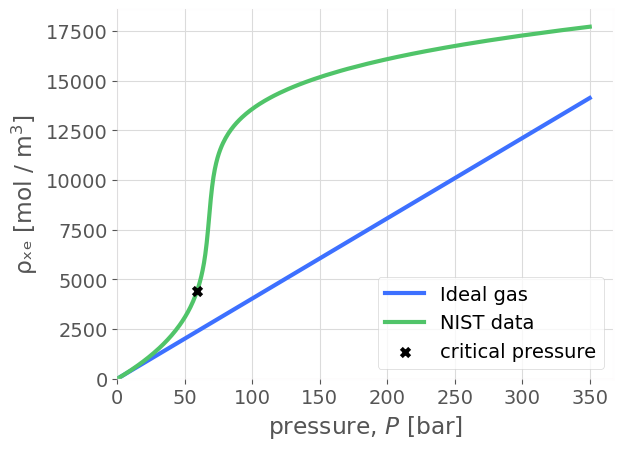

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


In [10]:
figure()
plot(P_range, ρ_ideal_gas, color="C0", label="Ideal gas", linewidth=3)
plot(P_range, ρ_xe(P_range), color="C2", label="NIST data", linewidth=3)
scatter(59.0, ρ_xe(59.0), color="black", label="critical pressure", marker="x", zorder=500, linewidth=3)
xlabel(L"pressure, $P$ [bar]")
ylabel("ρₓₑ [mol / m\$^3\$]")
ylim(ymin=0.0)
xlim(xmin=0.0)#, xmax=200)
legend()
grid(true)
savefig("figures/xenon_gas_density.pdf", bbox_inches="tight")

In [11]:
function ρ_xe_ads(P::Float64, xtal::String)
    M = xtal_to_M[xtal]
    K = xtal_to_K[xtal]
    return (M * K * P) / (1 + K * P)
end

ρ_xe_ads (generic function with 1 method)

In [12]:
Pδ = [0.00001, 100] # initial pressure range guess

2-element Array{Float64,1}:
   1.0e-5
 100.0

In [13]:
# radius of vessel needed
function r(P::Float64, xtal::String) # ads Xe storage
    return (3.0 * mol_desired_xe_propellant / (4.0 * π * ρ_xe_ads(P, xtal))) ^ (1/3)
end

function t(P::Float64, xtal::String) # ads Xe storage
    return P * r(P, xtal) / (2.0 * β * σ_y)
end

# mass of tank material needed
function mₜ(P::Float64, xtal::String) # ads Xe storage
    return 4.0 * π * (r(P, xtal) ^ 2.0) * t(P, xtal) * ρ_t
end

# mass of adsorbent needed
function mₐ(P::Float64, xtal::String) # ads Xe storage (of course)
    return xtal_to_ρ[xtal] * mol_desired_xe_propellant / ρ_xe_ads(P, xtal)
end

function optimum_storage(xtal::String) # ads Xe storage
    # use Optim.jl to find the minimum
    res = optimize(P -> (mₜ(P, xtal) + mₐ(P, xtal)), Pδ[1], Pδ[2])
    @assert res.converged "Optimization not successful."
    return res
end



function r(P::Float64) # bulk Xe storage
    return (3.0 * mol_desired_xe_propellant / (4.0 * π * ρ_xe(P))) ^ (1/3)
end

function t(P::Float64) # bulk Xe storage
    return P * r(P) / (2.0 * β * σ_y)
end

function mₜ(P::Float64)  # bulk Xe storage
    return 4.0 * π * (r(P) ^ 2.0) * t(P) * ρ_t
end

function optimum_storage() # bulk Xe storage
    return optimize(P -> mₜ(P[1]), Pδ[1], Pδ[2])
end

optimum_storage (generic function with 2 methods)

### Bulk Xe Storage

In [14]:
bulk_opt = optimum_storage()
P_range = range(10.0, 200.0, length=200)

10.0:0.9547738693467337:200.0

In [15]:
bulk_to_optimum_results = Dict()

bulk_to_optimum_results["storage pressure [bar]"] = bulk_opt.minimizer
bulk_to_optimum_results["tankage fraction"] = bulk_opt.minimum / mass_desired_xe_propellant
bulk_to_optimum_results["thickness [m]"] = t(bulk_opt.minimizer)
bulk_to_optimum_results["radius [m]"] = r(bulk_opt.minimizer)
bulk_to_optimum_results["mass of tank material [kg]"] = mₜ(bulk_opt.minimizer)

bulk_to_optimum_results

Dict{Any,Any} with 5 entries:
  "thickness [m]"              => 0.00225398
  "mass of tank material [kg]" => 7.2064
  "tankage fraction"           => 0.0809708
  "radius [m]"                 => 0.239683
  "storage pressure [bar]"     => 77.583

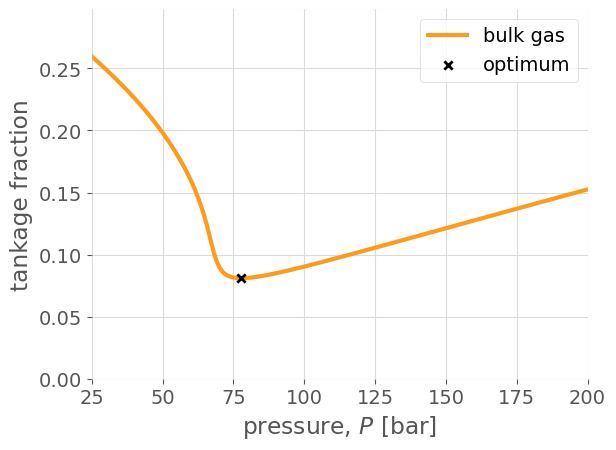

In [16]:
figure()
plot(P_range, mₜ.(P_range) / mass_desired_xe_propellant, color="C3", label="bulk gas", linewidth=3)
xlabel(L"pressure, $P$ [bar]")
ylabel("tankage fraction")
scatter([bulk_opt.minimizer], [bulk_opt.minimum] / mass_desired_xe_propellant, marker="x", color="black", label="optimum", zorder=500)
ylim(ymin=0.0)
xlim(xmin=25.0, xmax=200)
legend()
grid(true)
savefig("figures/bulk_gas_tankage_fraction.pdf", bbox_inches="tight")

In [17]:
function make_plots_bulk()
    println("optimum: ")
    println("\tstorage pressure [bar] = ", bulk_to_optimum_results["storage pressure [bar]"])
    println("\tmass of tank material [kg] = ", bulk_to_optimum_results["mass of tank material [kg]"])
    println("\ttankage fraction [kg] = ", bulk_to_optimum_results["tankage fraction"])
    
    figure(figsize=(8, 12))

    axs = [
            subplot2grid((6, 1), (0, 0)),
            subplot2grid((6, 1), (1, 0)),
            subplot2grid((6, 1), (2, 0), rowspan=2),
            subplot2grid((6, 1), (4, 0), rowspan=2)
            ]

    # tank radius
    axs[1].plot(P_range, r.(P_range), color="C0", linewidth=3)
    axs[1].set_ylabel("radius [m]", size=15)
    axs[1].set_title("bulk gas")
    axs[1].xaxis.set_ticklabels([])
    axs[1].xaxis.set_ticks_position("none")

    # tank thickness
    axs[2].plot(P_range, t.(P_range), color="C1", linewidth=3)
    axs[2].set_ylabel("thickness [m]", size=15)
    axs[2].xaxis.set_ticklabels([])
    axs[2].xaxis.set_ticks_position("none")
    
    # density of adsorbed xe
    axs[3].plot(P_range, ρ_xe.(P_range), color="C2", linewidth=3)
    axs[3].set_ylabel("ρₓₑ [mol / m\$^3\$]", size=15)
    axs[3].xaxis.set_ticklabels([])
    axs[3].xaxis.set_ticks_position("none")
    
    # tankage fraction
    axs[4].plot(P_range, mₜ.(P_range) / mass_desired_xe_propellant, color="C3", linestyle="-", label="tank walls", linewidth=3) 
    axs[4].plot(
                [
                bulk_to_optimum_results["storage pressure [bar]"], 
                bulk_to_optimum_results["storage pressure [bar]"]
                ],
                [0, bulk_to_optimum_results["mass of tank material [kg]"]] 
                    / mass_desired_xe_propellant,
                color="black", linestyle="--", zorder=500
                )
    axs[4].plot(
                [0, bulk_to_optimum_results["storage pressure [bar]"]],
                [
                bulk_to_optimum_results["mass of tank material [kg]"], 
                bulk_to_optimum_results["mass of tank material [kg]"]
                ] 
                / mass_desired_xe_propellant,
                color="black", linestyle="--", zorder=500
                )
    axs[4].scatter(bulk_to_optimum_results["storage pressure [bar]"],
                   bulk_to_optimum_results["mass of tank material [kg]"] / mass_desired_xe_propellant,
                color="black", marker="x", label="optimum", zorder=500, s=50
                    )

    axs[4].set_ylabel("tankage fraction", size=15)
    axs[4].legend(bbox_to_anchor=(1, 1))

    xlabel(L"pressure, $P$ [bar]", size=15)

    # manually ensure x lims
    for ax in axs
        ax.grid(true)
        ax.set_xlim(10.0, 150.0)
    end

    savefig("figures/shared_P_characteristics/bulk_gas_shared_P_characteristics.pdf", bbox_inches="tight")
end

make_plots_bulk (generic function with 1 method)

optimum: 


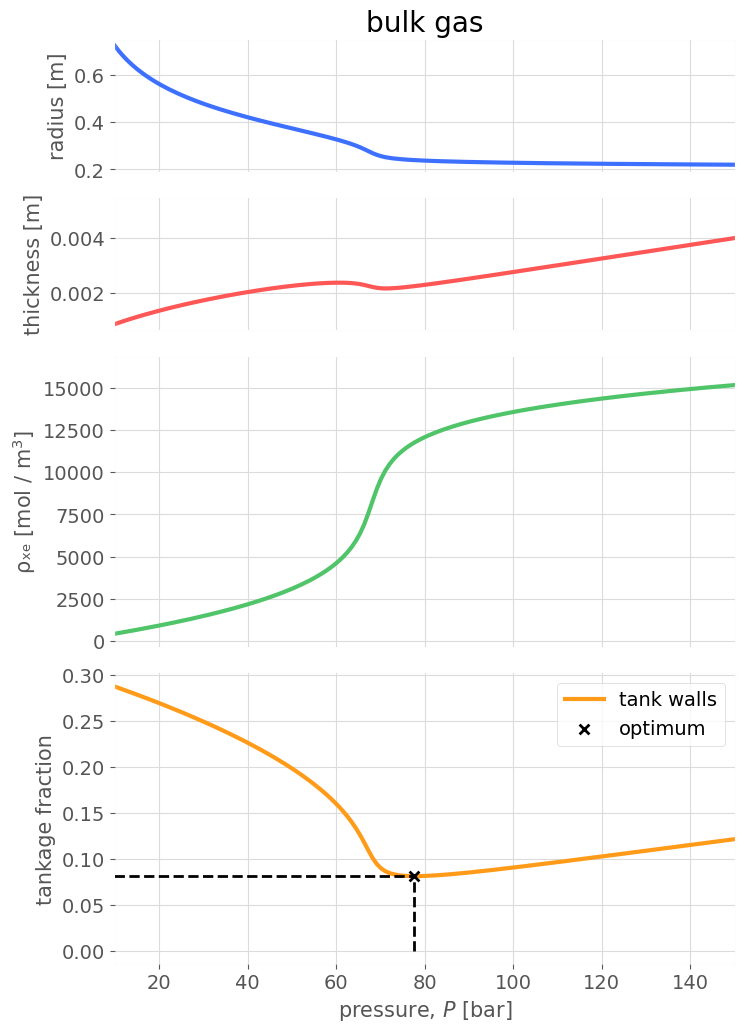

	storage pressure [bar] = 77.58300055605467
	mass of tank material [kg] = 7.206396794398056
	tankage fraction [kg] = 0.08097075049885456


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


In [18]:
make_plots_bulk()

### Adsorbed Xe Storage

In [19]:
P_range = range(1.0, 50.0, length=200)

1.0:0.24623115577889448:50.0

In [20]:
xtal_to_optimum_results = Dict()

for xtal in crystal_names
    opt = optimum_storage(xtal)
    xtal_to_optimum_results[xtal] = Dict()
    xtal_to_optimum_results[xtal]["storage pressure [bar]"] = opt.minimizer
    xtal_to_optimum_results[xtal]["tankage fraction"] = opt.minimum / mass_desired_xe_propellant
    xtal_to_optimum_results[xtal]["thickness [m]"] = t(opt.minimizer, xtal)
    xtal_to_optimum_results[xtal]["radius [m]"] = r(opt.minimizer, xtal)
    xtal_to_optimum_results[xtal]["mass of tank material [kg]"] = mₜ(opt.minimizer, xtal)
    xtal_to_optimum_results[xtal]["mass of xtal [kg]"] = mₐ(opt.minimizer, xtal)
    xtal_to_optimum_results[xtal]["total mass of tank [kg]"] = mₐ(opt.minimizer, xtal) + mₜ(opt.minimizer, xtal)
end

xtal_to_optimum_results

Dict{Any,Any} with 10 entries:
  "Ni-MOF-74"           => Dict{Any,Any}("total mass of tank [kg]"=>100.446,"th…
  "SBMOF-2"             => Dict{Any,Any}("total mass of tank [kg]"=>190.013,"th…
  "Activated-Carbon"    => Dict{Any,Any}("total mass of tank [kg]"=>138.909,"th…
  "CC3"                 => Dict{Any,Any}("total mass of tank [kg]"=>254.467,"th…
  "COF-103 (simulated)" => Dict{Any,Any}("total mass of tank [kg]"=>24.9604,"th…
  "SBMOF-1"             => Dict{Any,Any}("total mass of tank [kg]"=>485.22,"thi…
  "NiPyC2"              => Dict{Any,Any}("total mass of tank [kg]"=>208.609,"th…
  "HKUST-1"             => Dict{Any,Any}("total mass of tank [kg]"=>241.092,"th…
  "MOF-505"             => Dict{Any,Any}("total mass of tank [kg]"=>59.5148,"th…
  "Co-formate"          => Dict{Any,Any}("total mass of tank [kg]"=>301.077,"th…

In [79]:
findall(crystal_names .== "NiPyC2")

1-element Array{Int64,1}:
 9

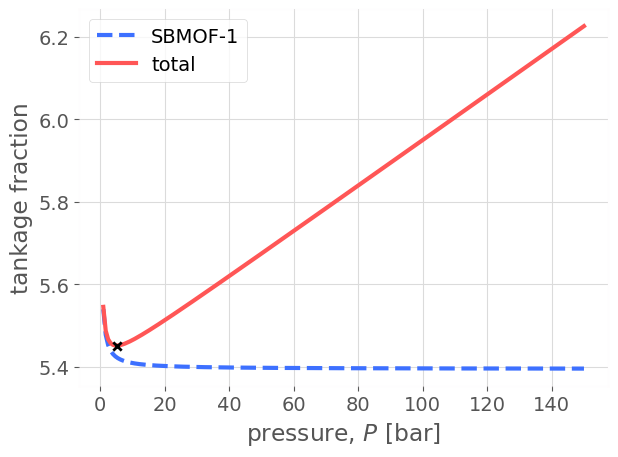

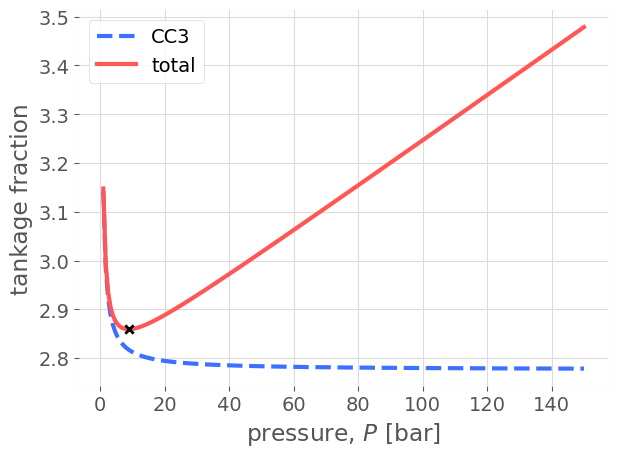

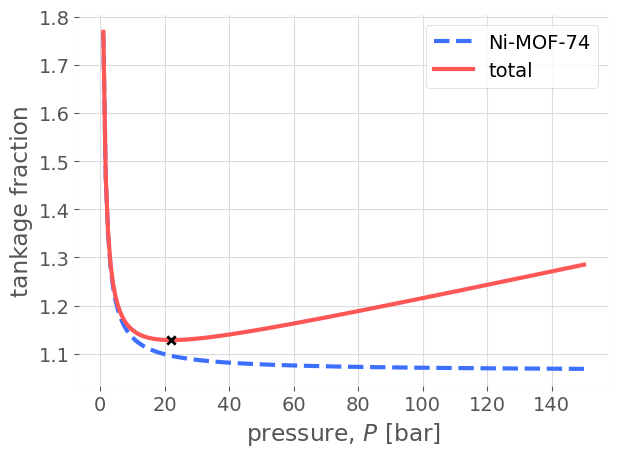

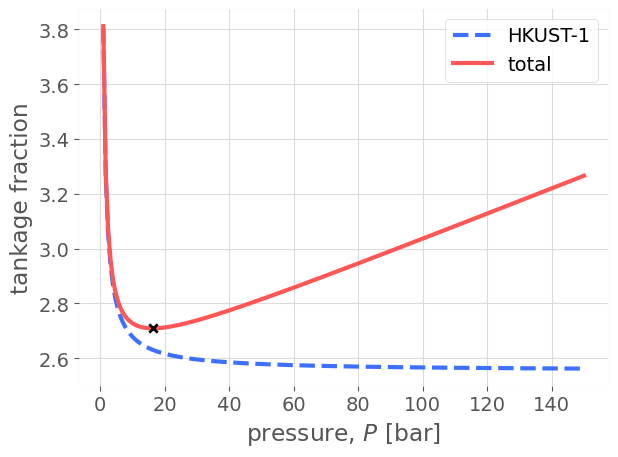

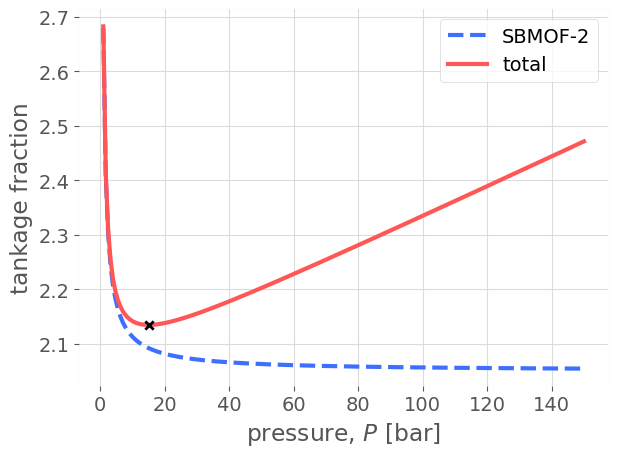

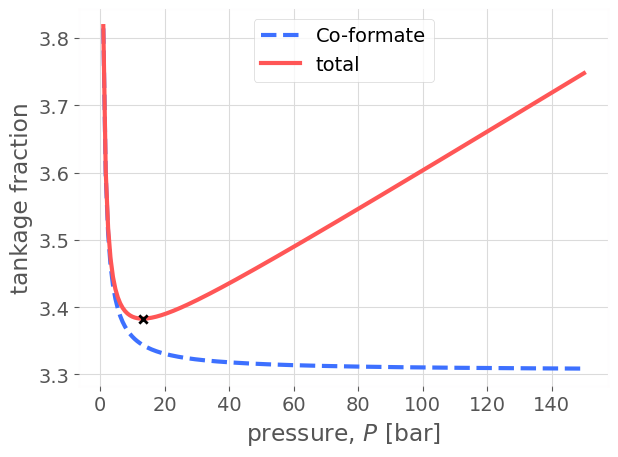

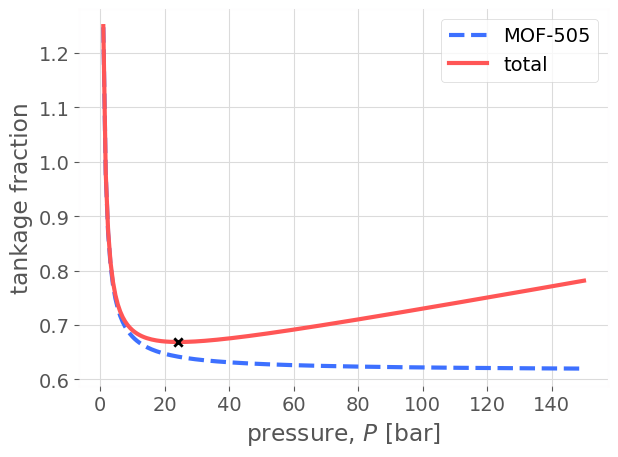

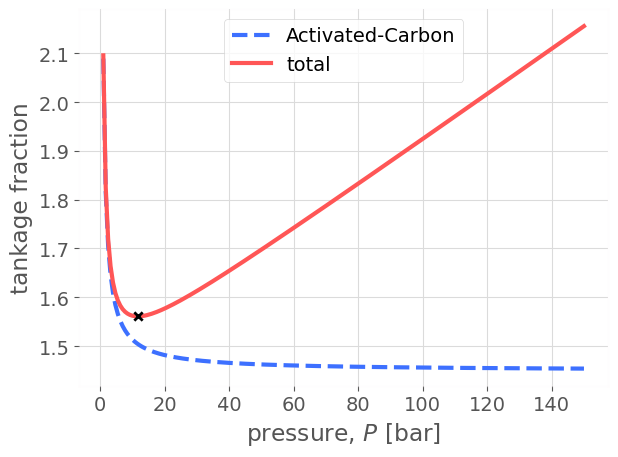

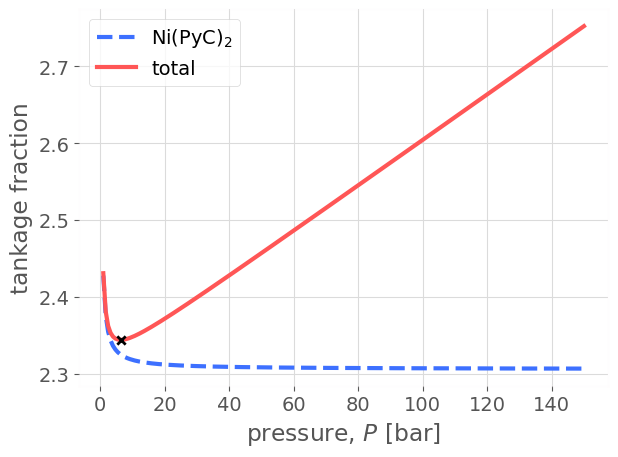

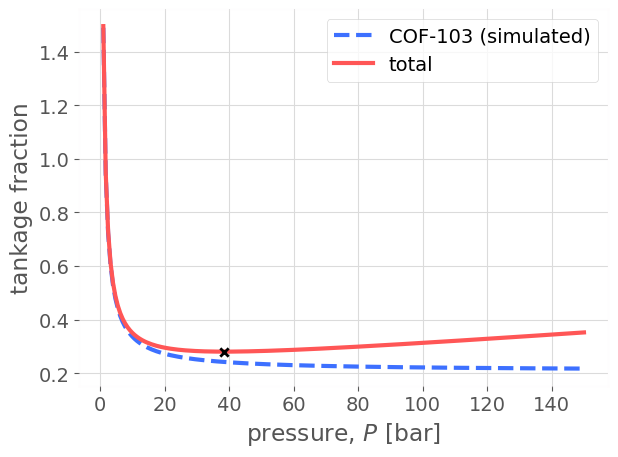

In [82]:
# adsorbent and total
for xtal in crystal_names
    figure()
    plot(P_range, mₐ.(P_range, xtal) / mass_desired_xe_propellant,
    color="C0", linestyle="--", linewidth=3,
    label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal))
    plot(P_range, (mₜ.(P_range, xtal) + mₐ.(P_range, xtal)) / mass_desired_xe_propellant, color="C1", label="total", linewidth=3)
    xlabel(L"pressure, $P$ [bar]")
    ylabel("tankage fraction")
    scatter(xtal_to_optimum_results[xtal]["storage pressure [bar]"], xtal_to_optimum_results[xtal]["tankage fraction"],
            marker="x", color="black", zorder=1000)
    legend()
    grid(true)
    tight_layout()
    savefig(string("figures/tankage_fractions/tankage_fraction_", xtal, ".pdf"), bbox_inches="tight")
end

In [22]:
P_range = range(1.0, 150.0, length=200)

function make_plots_ads(xtal::String)
     println("optimum: ")
     println("\tstorage pressure [bar] = ", xtal_to_optimum_results[xtal]["storage pressure [bar]"])
     println("\tmass of tank material [kg] = ", xtal_to_optimum_results[xtal]["mass of tank material [kg]"])
     println("\ttankage fraction [kg] = ", xtal_to_optimum_results[xtal]["tankage fraction"])
    
    figure(figsize=(8, 12))

    axs = [
            subplot2grid((6, 1), (0, 0)),
            subplot2grid((6, 1), (1, 0)),
            subplot2grid((6, 1), (2, 0), rowspan=2),
            subplot2grid((6, 1), (4, 0), rowspan=2)
            ]

    # tank radius
    axs[1].plot(P_range, r.(P_range, xtal), color="C0", linewidth=3)
    axs[1].set_ylabel("radius [m]", size=15)
    axs[1].set_title(xtal)
    axs[1].xaxis.set_ticklabels([])
    axs[1].xaxis.set_ticks_position("none")
    
    # tank thickness
    axs[2].plot(P_range, t.(P_range, xtal), color="C1", linewidth=3)
    axs[2].set_ylabel("thickness [m]", size=15)
    axs[2].xaxis.set_ticklabels([])
    axs[2].xaxis.set_ticks_position("none")
    
    # density of adsorbed xe
    axs[3].plot(P_range, ρ_xe_ads.(P_range, xtal), color="C2", linewidth=3)
    axs[3].set_ylabel("ρₓₑ [mol / m\$^3\$]", size=15)
    axs[3].xaxis.set_ticklabels([])
    axs[3].xaxis.set_ticks_position("none")
    
    # tankage fraction
    axs[4].plot(
                    [
                    xtal_to_optimum_results[xtal]["storage pressure [bar]"], 
                    xtal_to_optimum_results[xtal]["storage pressure [bar]"]
                    ],
                [0, xtal_to_optimum_results[xtal]["total mass of tank [kg]"]] 
                    / mass_desired_xe_propellant,
                color="black", linestyle="--", zorder=500
                )
    axs[4].plot(
                [0, xtal_to_optimum_results[xtal]["storage pressure [bar]"]],
                    [
                    xtal_to_optimum_results[xtal]["total mass of tank [kg]"], 
                    xtal_to_optimum_results[xtal]["total mass of tank [kg]"]
                    ] 
                    / mass_desired_xe_propellant,
                color="black", linestyle="--", zorder=500
                )
    axs[4].scatter(xtal_to_optimum_results[xtal]["storage pressure [bar]"],
                   xtal_to_optimum_results[xtal]["total mass of tank [kg]"] / mass_desired_xe_propellant,
                color="black", marker="x", label="optimum", zorder=500, s=50
                    )
    axs[4].plot(
                P_range, mₜ.(P_range, xtal) / mass_desired_xe_propellant, color="C3", linestyle="--", 
                label="tank walls", linewidth=3
                ) 
    axs[4].plot(
                P_range, mₐ.(P_range, xtal) / mass_desired_xe_propellant, color="C4", linestyle="-.", 
                label="adsorbent", linewidth=3
                )
    axs[4].plot(
                P_range, (mₜ.(P_range, xtal) + mₐ.(P_range, xtal)) / mass_desired_xe_propellant, color="C9", 
                label="total", linewidth=3
                )
    axs[4].set_ylabel("tankage fraction", size=15)
    axs[4].legend()

    xlabel(L"pressure, $P$ [bar]", size=15)

    # manually ensure x lims
    for ax in axs
        ax.grid(true)
        ax.set_xlim(0.0, 70.0)
    end

    savefig(string("figures/shared_P_characteristics/", xtal, "_shared_P_characteristics.pdf"), bbox_inches="tight")
end

make_plots_ads (generic function with 1 method)

optimum: 
	storage pressure [bar] = 5.117497962440876
	mass of tank material [kg] = 2.533170144195447
	tankage fraction [kg] = 5.451906708176
optimum: 
	storage pressure [bar] = 8.864939308240235
	mass of tank material [kg] = 3.7342937607272515
	tankage fraction [kg] = 2.8591817304197127
optimum: 
	storage pressure [bar] = 22.1082200521734
	mass of tank material [kg] = 2.9082519639527504
	tankage fraction [kg] = 1.1286109940339792
optimum: 
	storage pressure [bar] = 16.35452638321801
	mass of tank material [kg] = 7.01318147934797
	tankage fraction [kg] = 2.708894171352685
optimum: 
	storage pressure [bar] = 15.052411969944899
	mass of tank material [kg] = 3.7874825750331467
	tankage fraction [kg] = 2.1349794779867457
optimum: 
	storage pressure [bar] = 13.194161989339305
	mass of tank material [kg] = 3.471717090221405
	tankage fraction [kg] = 3.3828882566911576
optimum: 
	storage pressure [bar] = 24.292012056804094
	mass of tank material [kg] = 2.410904983398179
	tankage fraction [kg] 

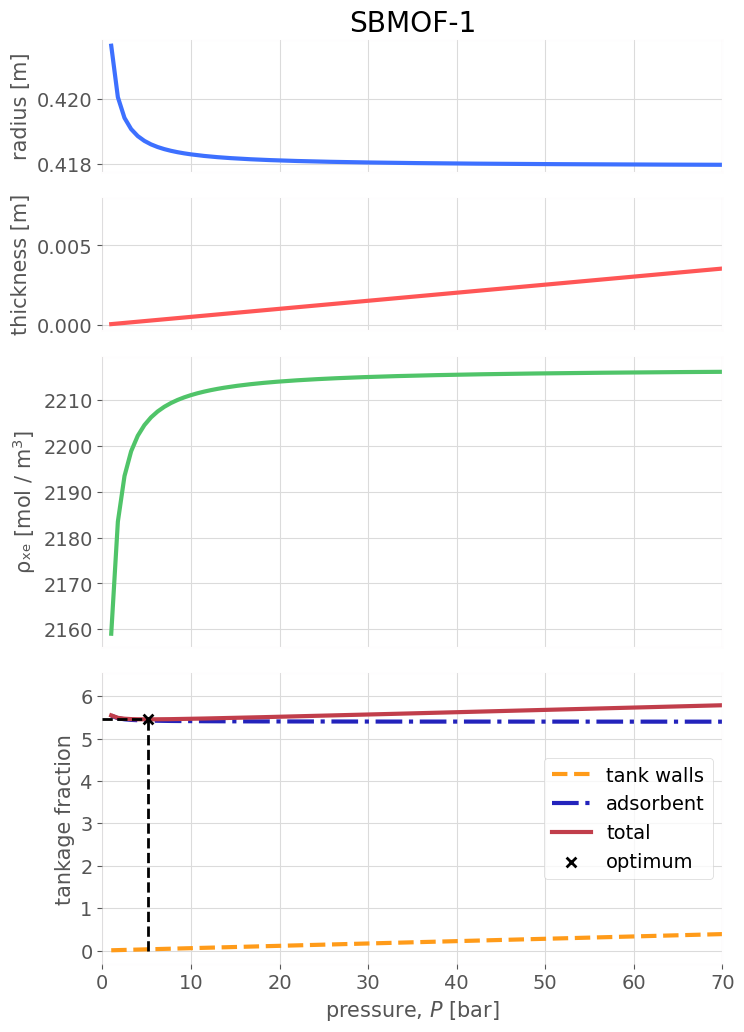

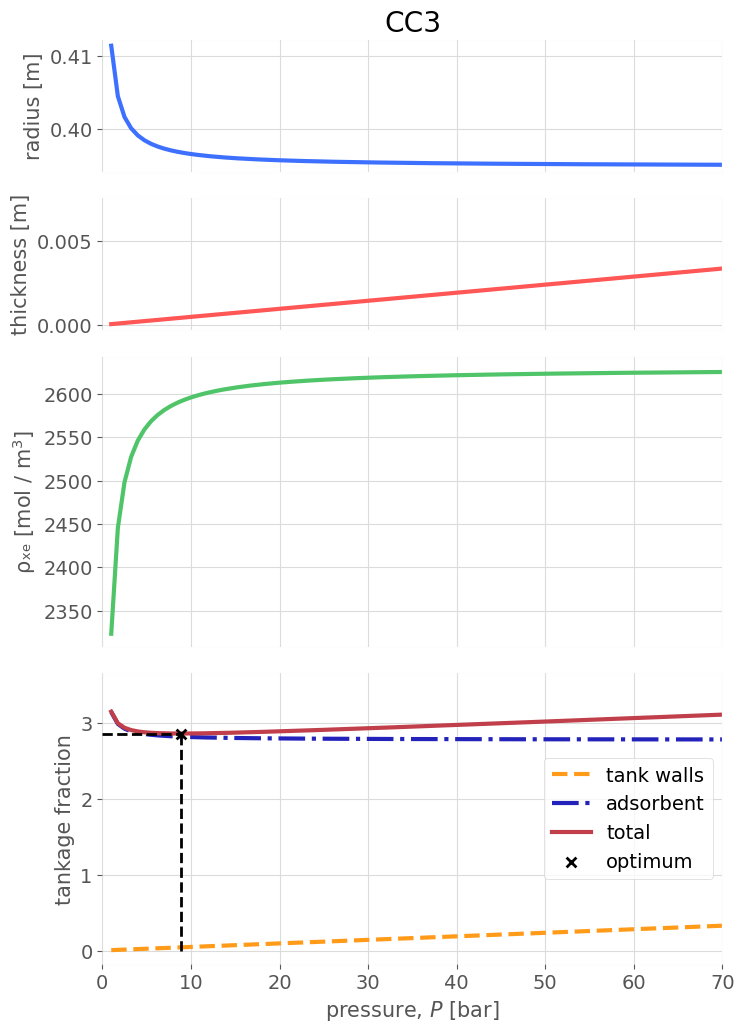

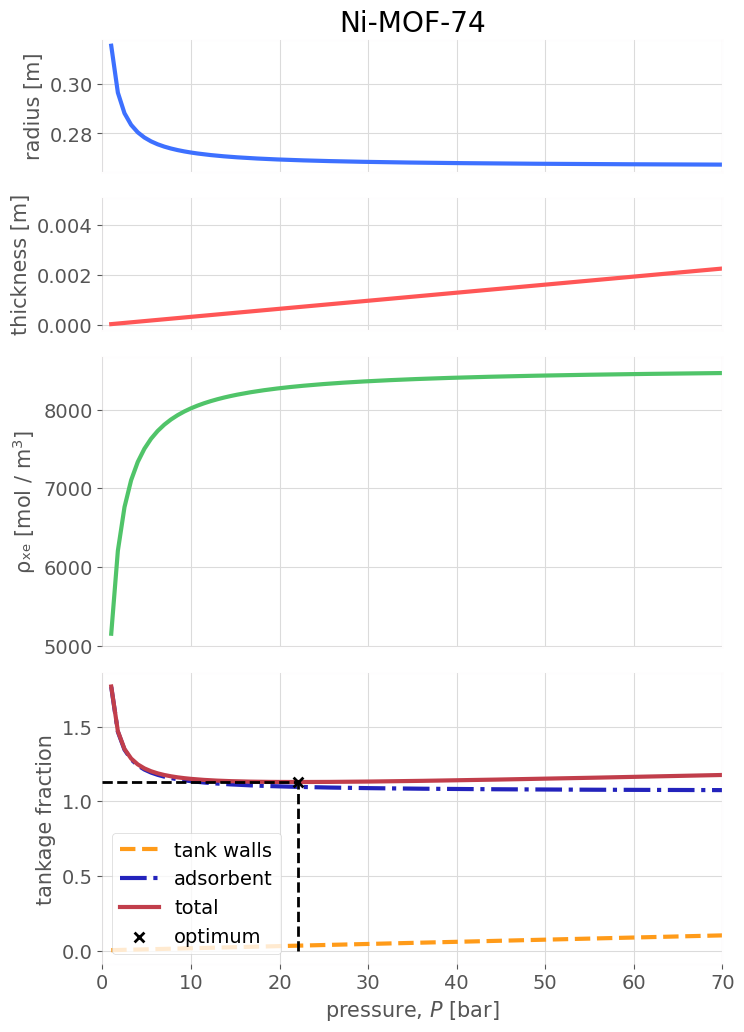

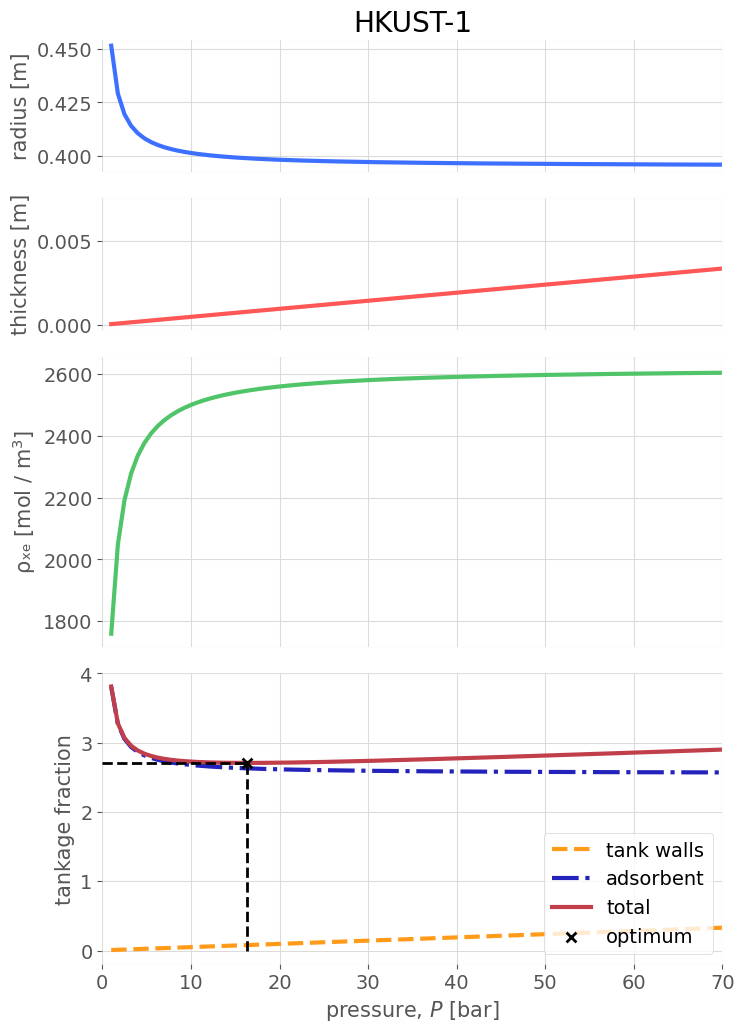

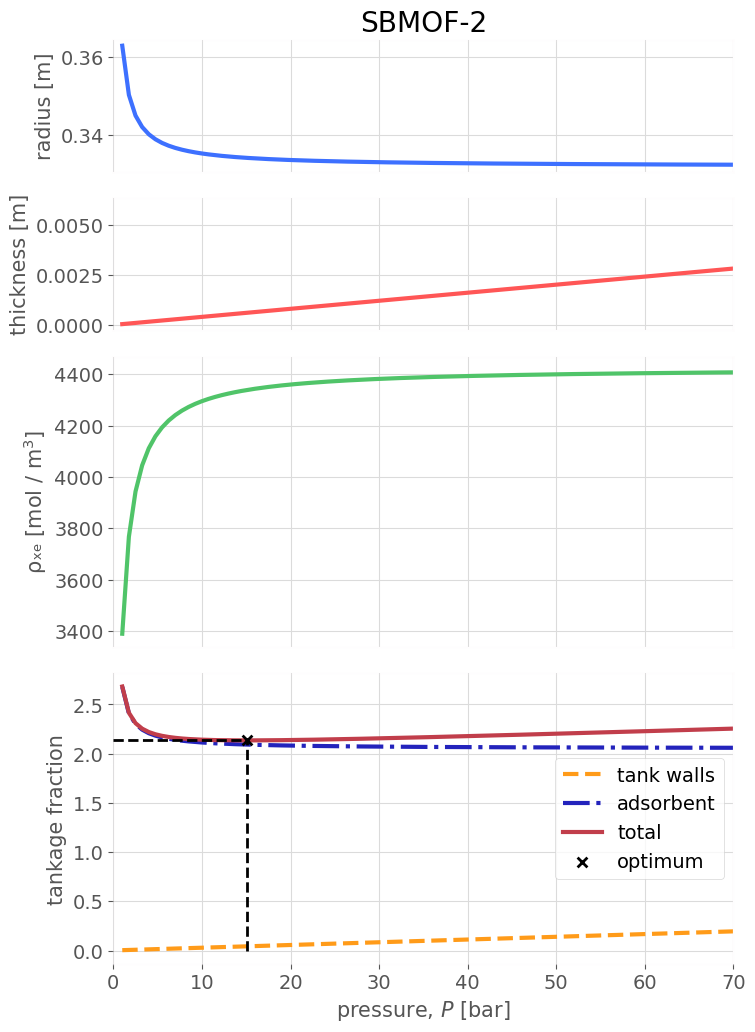

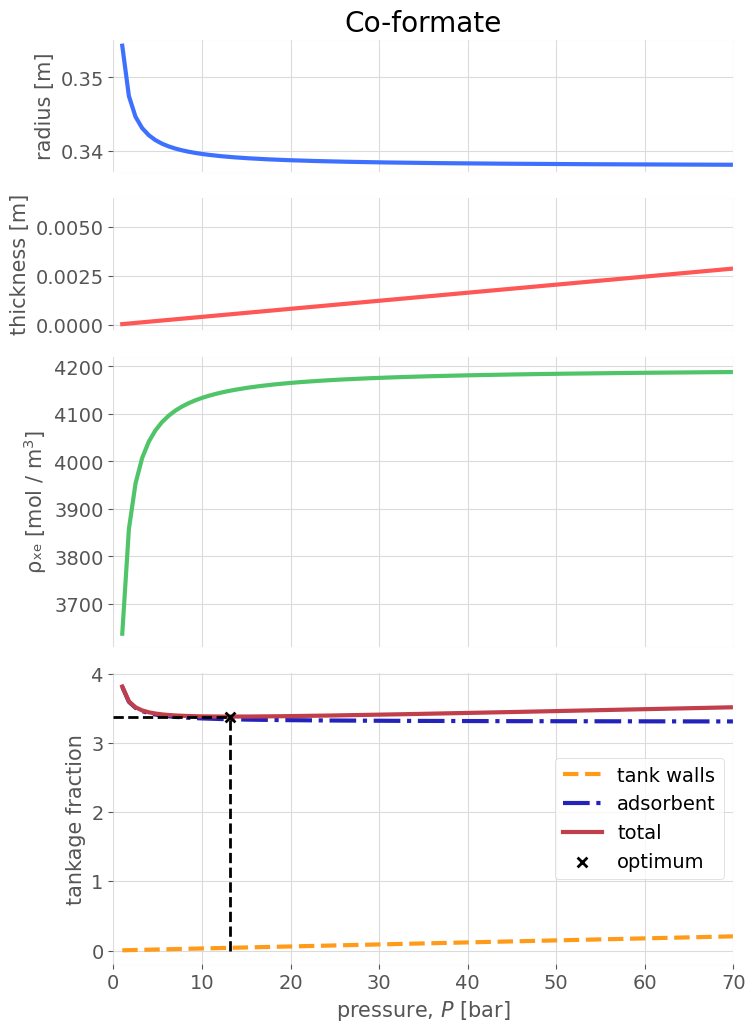

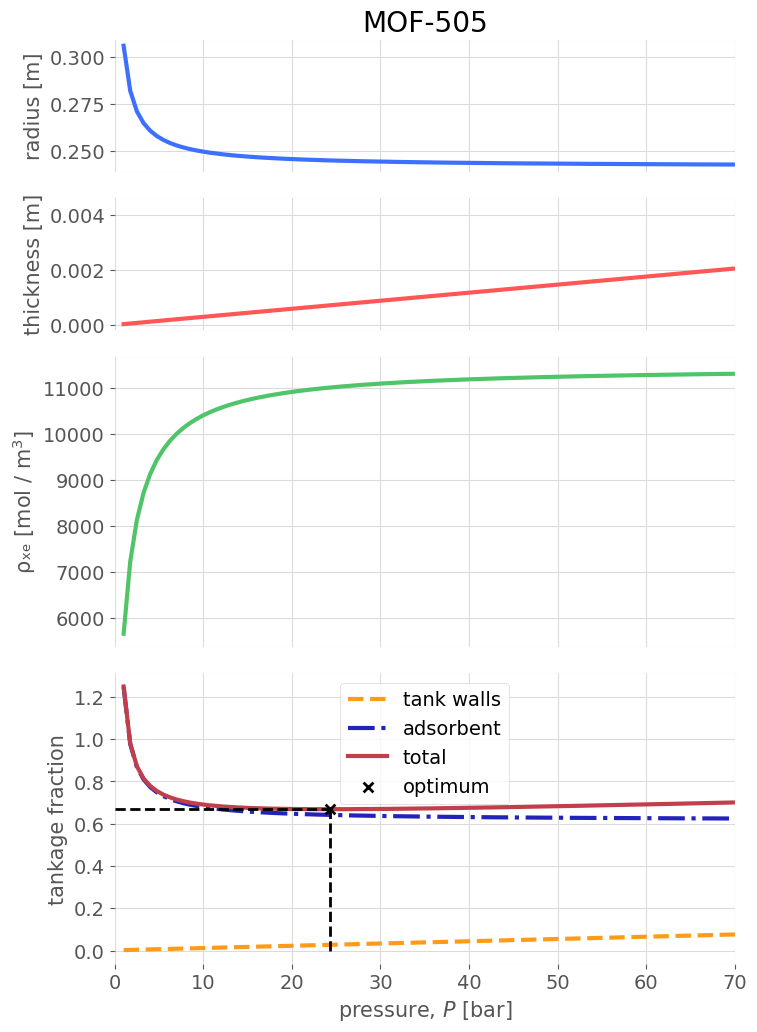

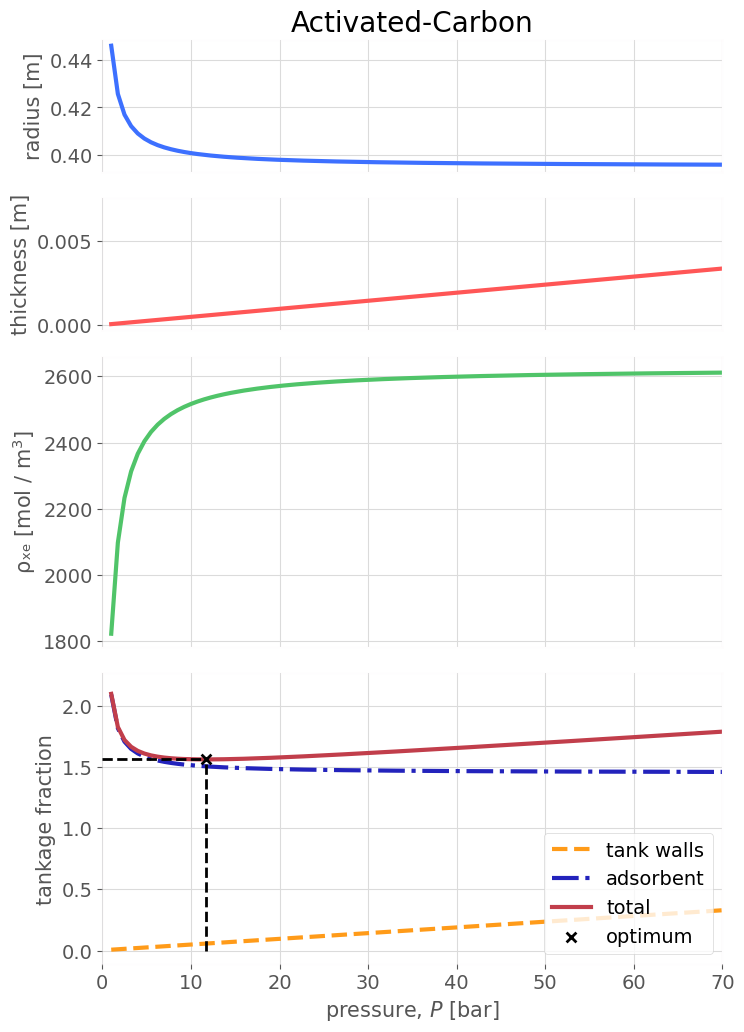

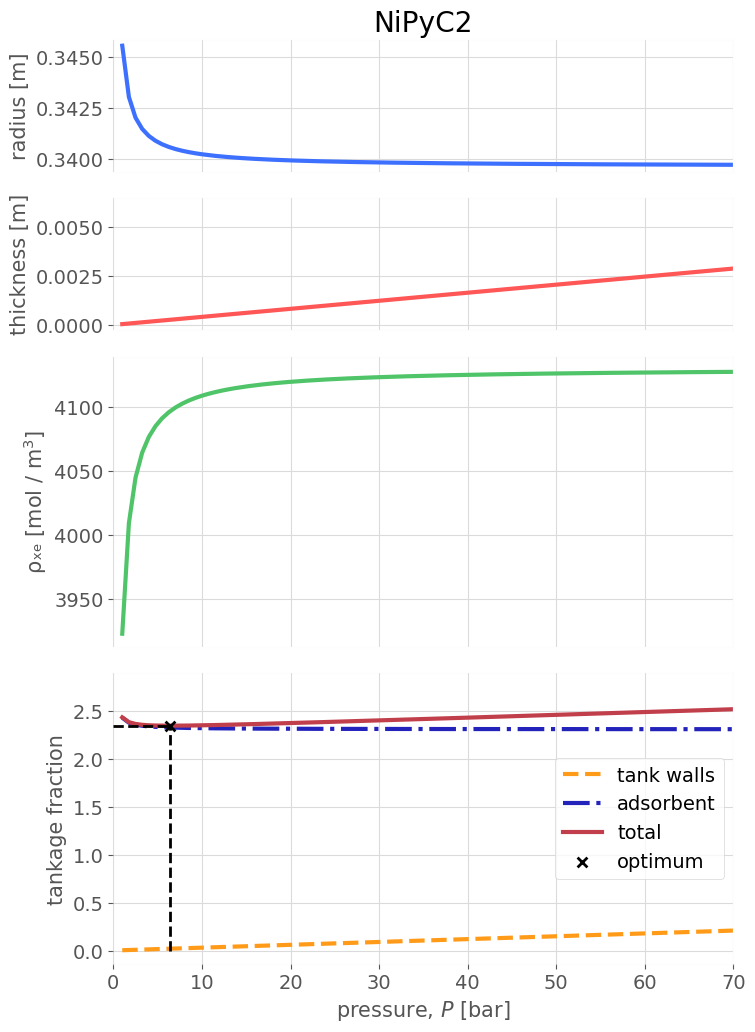

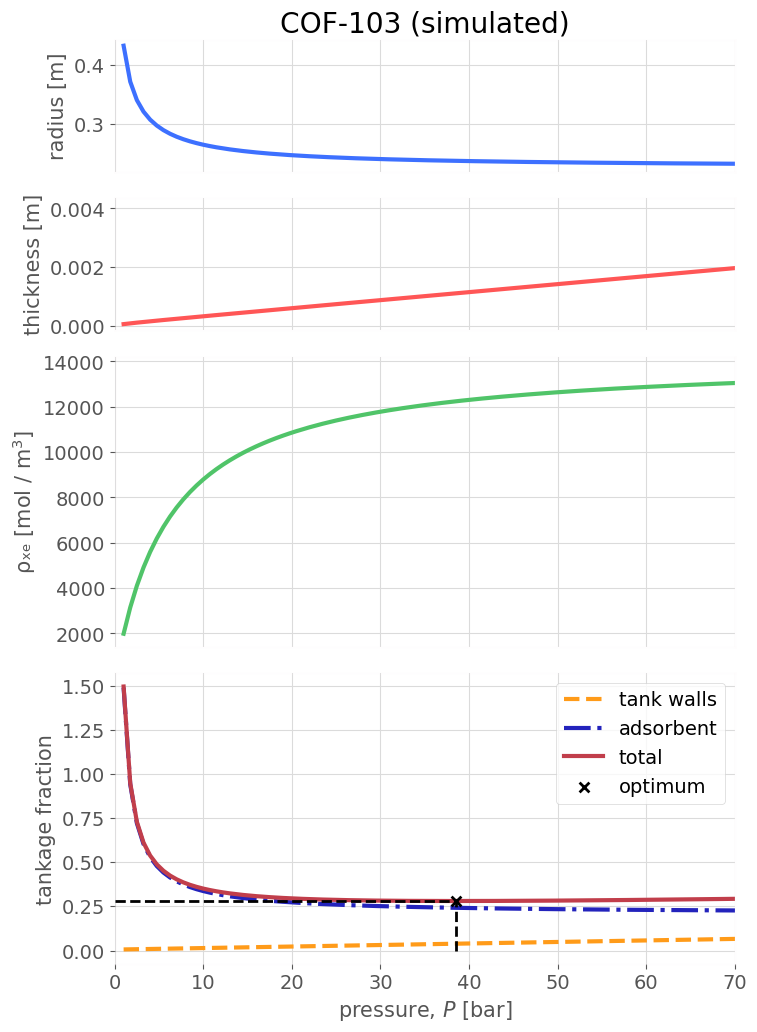

optimum: 
	storage pressure [bar] = 38.485667290002134
	mass of tank material [kg] = 3.43246220982516
	tankage fraction [kg] = 0.2804543354540887


In [23]:
for xtal in crystal_names
    make_plots_ads(xtal)
end

### visualizing the reduction in storage volume given by the MOFs

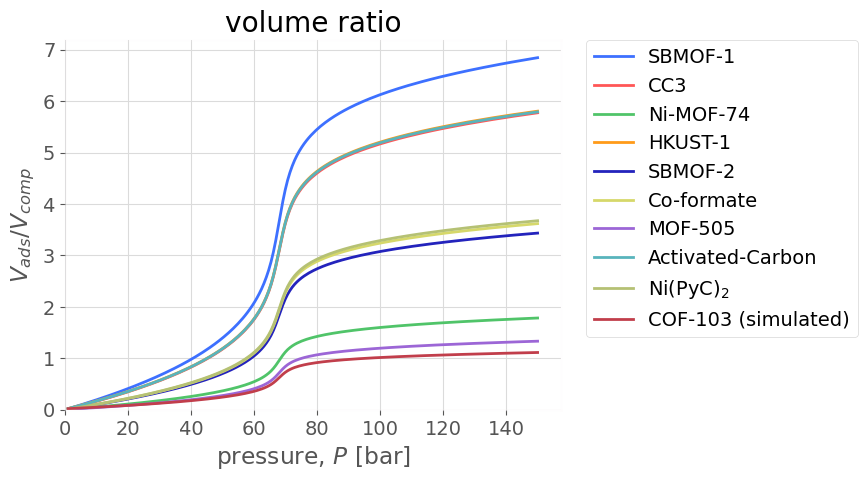

In [83]:
figure()
for xtal in crystal_names
    plot(P_range, 
        r.(P_range, xtal) .^ 3 ./      # ads
        r.(P_range) .^ 3,              # bulk
        label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), color=xtal_to_color[xtal])
end
xlabel(L"pressure, $P$ [bar]")
ylabel(L"$V_{ads} / V_{comp}$")
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
ylim(ymin=0.0)
xlim(xmin=0.0)
title("volume ratio")     
savefig("figures/volume_ratio.pdf", bbox_inches="tight")

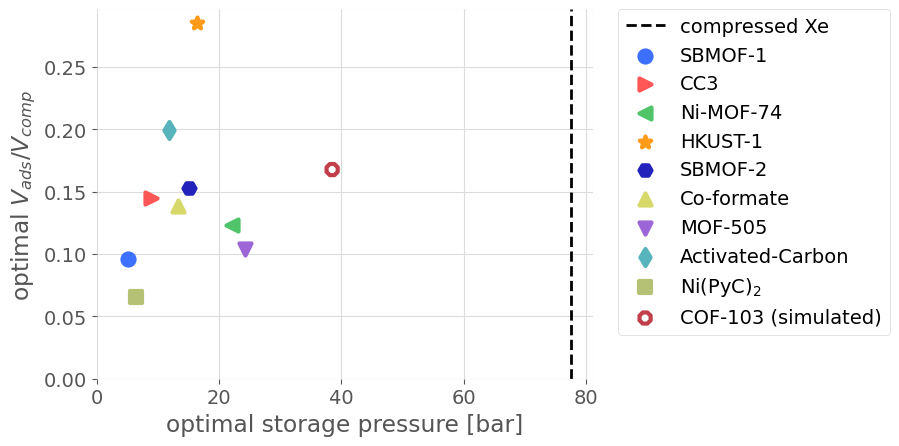

In [84]:
figure()
xlabel("optimal storage pressure [bar]")
ylabel(L"optimal $V_{ads} / V_{comp}$")
for xtal in crystal_names
    # find ratio of volumes at this optimal storage pressure
    scatter(xtal_to_optimum_results[xtal]["storage pressure [bar]"],
            r(xtal_to_optimum_results[xtal]["storage pressure [bar]"], xtal) ^ 3 ./      # ads
            r(xtal_to_optimum_results[xtal]["storage pressure [bar]"]) ^ 3,              # bulk, 
        label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false,
        color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal], 
        edgecolor=xtal_to_color[xtal], lw=3)
end

axvline(x=[bulk_opt.minimizer], linestyle="--", color="black", label="compressed Xe")
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/opt_storage_P_vs_opt_volume.pdf", bbox_inches="tight")

### optimal storage pressure vs. tankage fraction

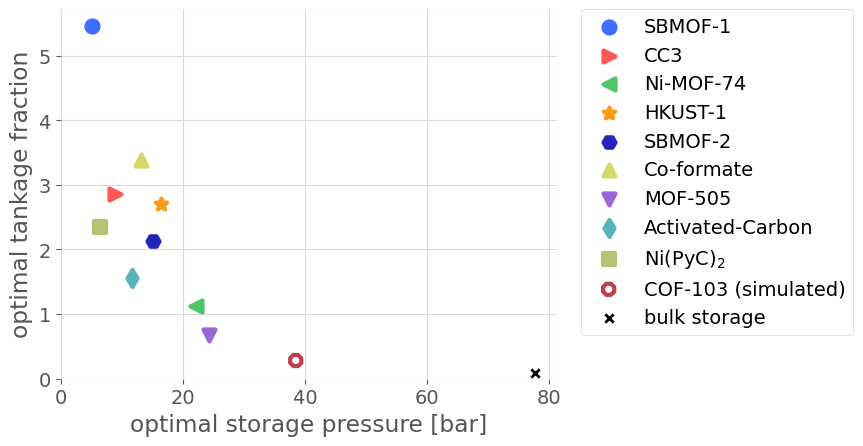

In [85]:
figure()
xlabel("optimal storage pressure [bar]")
ylabel("optimal tankage fraction")
for xtal in crystal_names
    scatter(xtal_to_optimum_results[xtal]["storage pressure [bar]"],
            xtal_to_optimum_results[xtal]["tankage fraction"],
        label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false, 
        color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal], 
        edgecolor=xtal_to_color[xtal], lw=3)
end

scatter([bulk_opt.minimizer], [bulk_opt.minimum] / mass_desired_xe_propellant, 
        marker="x", color="black", label="bulk storage")

ylim(ymin=-0.001)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/opt_storage_P_vs_opt_tankages_fraction.pdf", bbox_inches="tight")

In [38]:
bulk_to_optimum_results

Dict{Any,Any} with 5 entries:
  "thickness [m]"              => 0.00225398
  "mass of tank material [kg]" => 7.2064
  "tankage fraction"           => 0.0809708
  "radius [m]"                 => 0.239683
  "storage pressure [bar]"     => 77.583

In [37]:
xtal_to_optimum_results["MOF-505"]

Dict{Any,Any} with 7 entries:
  "total mass of tank [kg]"    => 59.5148
  "thickness [m]"              => 0.000721498
  "mass of tank material [kg]" => 2.4109
  "tankage fraction"           => 0.668705
  "mass of xtal [kg]"          => 57.1039
  "radius [m]"                 => 0.245033
  "storage pressure [bar]"     => 24.292

In [29]:
xtal_to_optimum_results["COF-103 (simulated)"]["radius [m]"]

0.23645876128595597

In [109]:
# With changing radius as size
scaler = 500

figure()
xlabel("optimal storage pressure [bar]")
ylabel("optimal tankage fraction")
for xtal in crystal_names
    scatter(xtal_to_optimum_results[xtal]["storage pressure [bar]"],
            xtal_to_optimum_results[xtal]["tankage fraction"],
        label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), clip_on=false, 
        color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal], 
        edgecolor=xtal_to_color[xtal], lw=3, s=xtal_to_optimum_results[xtal]["radius [m]"] ^ 2 * scaler)
end

xtal_to_text_pos = Dict(crystal => [1.0, 0.1] for crystal in crystal_names)

for i = 1:length(crystal_names)
    text(
        xtal_to_optimum_results[crystal_names[i]]["storage pressure [bar]"]+xtal_to_text_pos[crystal_names[i]][1], 
        xtal_to_optimum_results[crystal_names[i]]["tankage fraction"]+xtal_to_text_pos[crystal_names[i]][2],
        (crystal_names[i] == "NiPyC2" ? L"Ni(PyC)$_2$" : crystal_names[i]), fontsize=10
        )
end

scatter(bulk_opt.minimizer, bulk_opt.minimum / mass_desired_xe_propellant, 
        color="black", label="bulk storage", s=bulk_to_optimum_results["radius [m]"] ^ 2 * scaler)
text(bulk_opt.minimizer-14.0, bulk_opt.minimum/mass_desired_xe_propellant+0.1, "bulk storage", fontsize=10)

ylim(ymin=-0.1)
xlim(xmin=0.0)
tight_layout()
savefig("figures/opt_storage_P_vs_opt_tankages_fraction_s_radius.pdf", bbox_inches="tight")

MethodError: MethodError: no method matching zero(::LaTeXString)
Closest candidates are:
  zero(!Matched::Type{Missing}) at missing.jl:103
  zero(!Matched::Type{LibGit2.GitHash}) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\LibGit2\src\oid.jl:220
  zero(!Matched::Type{Pkg.Resolve.VersionWeight}) at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Pkg\src\Resolve\versionweights.jl:15
  ...

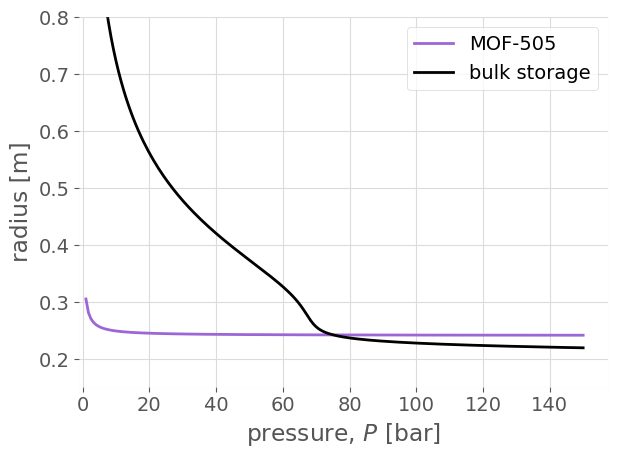

In [62]:
# The higher the ability to densify gas, the smaller the tank will be and become comparable to bulk xenon gas storage.
# Points are all taken at their optimal storage pressures where tank mass is at its minimum.

figure()
plot(P_range, r.(P_range, "MOF-505"), color=xtal_to_color["MOF-505"], label="MOF-505")
plot(P_range, r.(P_range), color="black", label="bulk storage")
xlabel(L"pressure, $P$ [bar]")
ylabel("radius [m]")
xlim(xmin=-1.0)
ylim(ymax=0.8)
tight_layout()
legend()
savefig("figures/bulk_vs_MOF-505_radius.pdf")

#### crystal density of adsorbent material affects tankage fraction

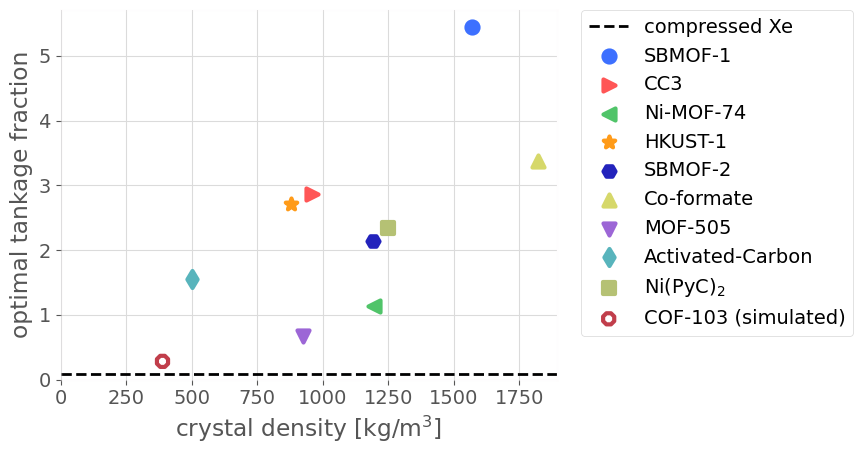

In [87]:
figure()
xlabel(L"crystal density [kg/m$^3$]")
ylabel("optimal tankage fraction")
for xtal in crystal_names
    scatter(xtal_to_ρ[xtal], xtal_to_optimum_results[xtal]["tankage fraction"],
    label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false,
    color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal],
    edgecolor=xtal_to_color[xtal], lw=3)
end

axhline(
        y=[bulk_opt.minimum] / mass_desired_xe_propellant, linestyle="--", 
        color="black", label="compressed Xe"
        )

ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/crystal_density_vs_opt_tankage_fraction.pdf", bbox_inches="tight")

### Langmuir characteristics vs tankage fraction

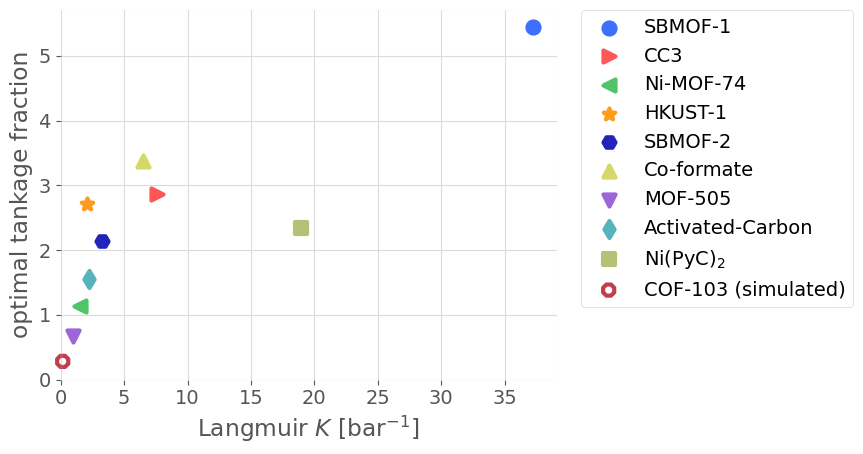

In [88]:
figure()
xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel("optimal tankage fraction")
for xtal in crystal_names
    scatter(xtal_to_K[xtal], xtal_to_optimum_results[xtal]["tankage fraction"],
    label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false,
    color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal],
    edgecolor=xtal_to_color[xtal], lw=3)
end
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/langmuir_K_vs_opt_tankage_fraction.pdf", bbox_inches="tight")

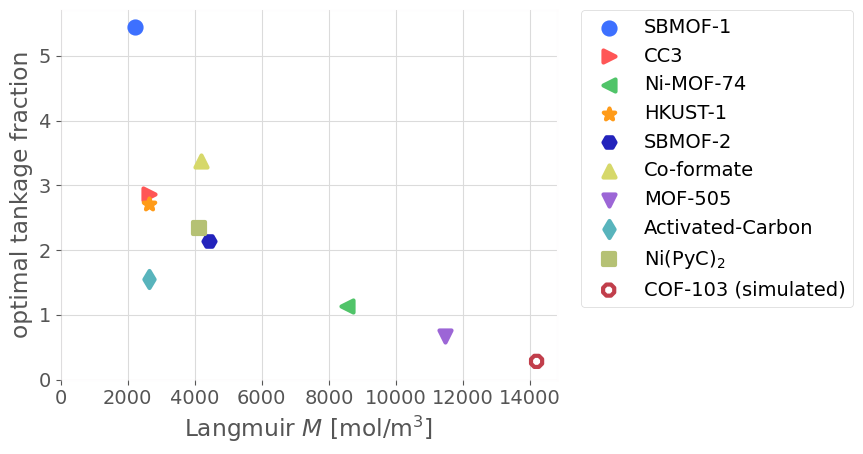

In [89]:
figure()
xlabel(L"Langmuir $M$ [mol/m$^3$]")
ylabel("optimal tankage fraction")
for xtal in crystal_names
    scatter(xtal_to_M[xtal], xtal_to_optimum_results[xtal]["tankage fraction"],
    label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false,
    color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal],
    edgecolor=xtal_to_color[xtal], lw=3)
end
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/langmuir_M_vs_opt_tankage_fraction.pdf", bbox_inches="tight")

### mass of tank needed, partitioned by adsorbant material vs. tank material

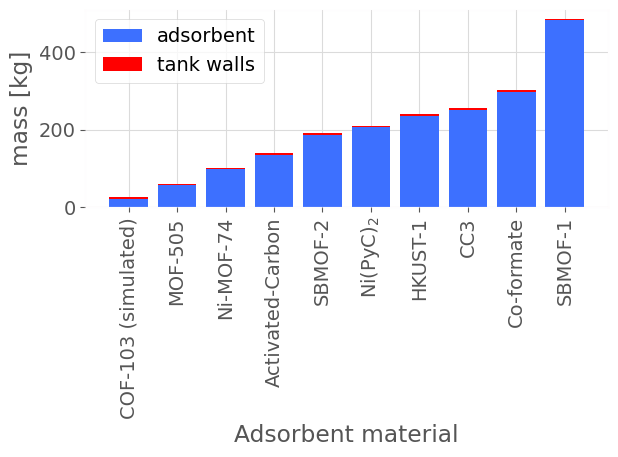

In [108]:
ids = 1:length(xtal_to_optimum_results)
ids_sorted = sortperm([xtal_to_optimum_results[xtal]["tankage fraction"] for xtal in keys(xtal_to_optimum_results)])                      

figure()
xlabel("Adsorbent material")
ylabel("mass [kg]")
m_xtal = [xtal_to_optimum_results[xtal]["mass of xtal [kg]"] for xtal in keys(xtal_to_optimum_results)]
m_tank_walls = [xtal_to_optimum_results[xtal]["mass of tank material [kg]"] for xtal in keys(xtal_to_optimum_results)]
bar(ids, m_xtal[ids_sorted], label="adsorbent")
bar(ids, m_tank_walls[ids_sorted], bottom=m_xtal[ids_sorted],label="tank walls", color="red")

legend()
xticks(ids, replace(collect(keys(xtal_to_optimum_results))[ids_sorted], "NiPyC2" => L"Ni(PyC)$_2$"), rotation="vertical")
tight_layout()
savefig("figures/contribution_mass_by_adsorbent.pdf", bbox_inches="tight")